In [1]:
import os
import platform
import pandas as pd
import numpy as np
from glob import glob
import pickle
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay,
                             balanced_accuracy_score, classification_report,
                             confusion_matrix, f1_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score)
from sklearn.utils import class_weight, shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import (BatchNormalization, Conv3D, Dense,
                                     Dropout, Flatten, GlobalAveragePooling3D,
                                     MaxPooling3D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.client import device_lib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Code from utils.py**

In [2]:
def model_lr_schedule(initial_lr=0.0001,decay=0.96):
    """Summary

    Args:
        initial_lr (float, optional): Initial learning rate to be set

    Returns:
        TYPE: Learning rate scheduler for Keras
    """
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_lr,
                                                              decay_steps=100000,
                                                              decay_rate=decay,
                                                              staircase=True)
    return lr_schedule


def get_correct_labels_mrnet(filenames, labels_dataframe):
    """Summary

    Args:
        filenames (list): List of filenames of the MRI scans
        labels_dataframe (pd.Dataframe): Dataframe with all MRNet cases and labels

    Returns:
        list: List of corresponding labels for given MRNet MRI filenames
    """
    labels = []
    for file in filenames:
        name = os.path.normpath(file).split(os.sep)[-1]
        case_name = name.split('.')[0]
        label = labels_dataframe.loc[labels_dataframe['Case'] == case_name, 'ACL'].tolist()[0]
        labels.append(label)
    return labels

def compute_class_weights(y_train):
    """Summary

    Args:
        y_train (list): List of labels

    Returns:
        dict: A dictionary of labels and their corresponding class weights
    """
    class_weights = dict(zip(np.unique(y_train),
                             class_weight.compute_class_weight(class_weight='balanced',
                                                               classes=np.unique(y_train),
                                                               y=y_train)))
    return class_weights


def batch_generator(filenames, labels, batch_size):
    '''
    This function loads the respective filenames and labels in the memory 
    based on the parameter batch size. It helps to control the amount of
    RAM being consumed as the datasets are large.

    Args:
        filenames (list): List of file paths to the MRI
        labels (list): List of corresponding labels of the MRI
        batch_size (int): Batch size

    Yields:
        tuple: Tuple of list of loaded MRI files and corresponding labels
    '''
    N = len(filenames)
    i = 0
    random_state_counter = 610
    filenames, labels = shuffle(filenames, labels, random_state=random_state_counter + 69)  # Shuffle at the start
    while True:
        batch_images = []
        batch_filenames = filenames[i:i + batch_size]
        for file in batch_filenames:
            mri_vol = np.load(file)
            mri_vol = np.expand_dims(mri_vol, axis=3)  # Adding extra axis for making it compatible for 3D Convolutions
            batch_images.append(mri_vol)
        batch_labels = labels[i:i + batch_size]
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)
        yield (batch_images, batch_labels)
        i = i + batch_size
        if i + batch_size > N:
            i = 0
            random_state_counter += 1
            filenames, labels = shuffle(filenames, labels, random_state=random_state_counter + 69)  # Shuffle at the end of each epoch
            
            
            
def model_callback_checkpoint(model_name, model_store_path='Models'):
    """Summary

    Args:
        model_name (str): Name of the model
        model_store_path (str, optional): Path to store the models

    Returns:
        TYPE: Keras checkpoint callback to store the best model
    """
    file_name = f"{model_store_path}/{model_name}/{model_name}.h5"

    # For running code on Windows
    if platform.system() == "Windows":
        file_name = file_name.replace('/', '\\')

    checkpoint_callback = keras.callbacks.ModelCheckpoint(file_name,
                                                          save_best_only=True)
    return checkpoint_callback

def model_callback_earlystopping():
    """Summary

    Returns:
        TYPE: Keras earlystopping callback for monitoring Validation Loss
    """
    earlystopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           patience=10,
                                                           verbose=1,
                                                           restore_best_weights=True)
    return earlystopping_callback


def store_model_history(model_name, model_history, model_history_path='Models'):
    """Summary

    Args:
        model_name (str): Model name
        model_history (TYPE): Keras model history
        model_history_path (str, optional): Path to store model history
    """
    file_name = f"{model_history_path}/{model_name}/{model_name}-history.pck"

    # For running code on Windows
    if platform.system() == "Windows":
        file_name = file_name.replace('/', '\\')

    parent_directory = os.path.dirname(file_name)
    if not os.path.exists(parent_directory):
        os.makedirs(parent_directory, exist_ok=True)

    with open(file_name, 'wb') as fh:
        pickle.dump(model_history, fh)
        
        
# Function to plot Accuracy and Loss of a model

def plot_acc_loss(model_history):
    """Summary

    Args:
        model_history (TYPE): Model history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=160)

    acc = model_history['accuracy']
    val_acc = model_history['val_accuracy']

    # Get number of epochs
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy per epoch
    ax1.plot(epochs, acc, label="Training Accuracy")
    ax1.plot(epochs, val_acc, label="Validation Accuracy")
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('EPOCHS')
    ax1.set_ylabel('ACCURACY')
    ax1.legend()

    loss = model_history['loss']
    val_loss = model_history['val_loss']
    
    # Plot training and validation loss per epoch
    ax2.plot(epochs, loss, label="Training Loss")
    ax2.plot(epochs, val_loss, label="Validation Loss")
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('EPOCHS')
    ax2.set_ylabel('LOSS')
    ax2.legend()
    # plt.show()

def predict_batch_generator(filenames, batch_size):
    '''
    This function loads the respective filenames and labels in the memory 
    based on the parameter batch size. It helps to control the amount of
    RAM being consumed as the datasets are large.

    Args:
        filenames (list): List of filenames of MRI
        batch_size (int): Batch size

    Yields:
        list: List of loaded MRIs
    '''
    N = len(filenames)
    i = 0
    while i < N:
        batch_images = []
        batch_filenames = filenames[i:i + batch_size]
        for file in batch_filenames:
            mri_vol = np.load(file)
            mri_vol = np.expand_dims(mri_vol, axis=3)  # Adding extra axis for making it compatible for 3D Convolutions
            batch_images.append(mri_vol)
        batch_images = np.array(batch_images)
        yield batch_images
        i = i + batch_size
        
def calculate_best_cutoff_threshold(labels, predicted_probs):
    """Summary

    Args:
        labels (list): List of true labels
        predicted_probs (list): List of predicted probabilities

    Returns:
        TYPE: Description
    """
    # Calculate PR Curve
    precision, recall, thresholds = precision_recall_curve(labels, predicted_probs)

    # Convert to f score
    fscore = (2 * precision * recall) / (precision + recall)

    # Locate the index of the largest f score
    ix = np.argmax(fscore)
    print('\nBest cutoff Threshold = %f, F-Score = %.3f' % (thresholds[ix], fscore[ix]))
    return thresholds[ix]

# Function for Model Evaluation

def evaluate_model(true_labels, predicted_labels, predicted_probs, label_names):
    """Summary

    Args:
        true_labels (list): List of true labels
        predicted_labels (list): List of predicted labels
        predicted_probs (list): List of predicted probabilities
        label_names (list): List of labels
    """
    print('\nEvaluation Metrics:\n')
    # Check for multi-class, else proceed for binary
    if len(label_names) > 2:
        print(f"Balanced Accuracy : {round(balanced_accuracy_score(true_labels, predicted_labels), 2)}")
        print(f"Precision : {round(precision_score(true_labels, predicted_labels, average='weighted'), 2)}")
        print(f"Recall : {round(recall_score(true_labels, predicted_labels, average='weighted'), 2)}")
        print(f"F1 Score: {round(f1_score(true_labels, predicted_labels, average='weighted'), 2)}")
        print(f"ROC AUC Score : {round(roc_auc_score(true_labels, predicted_probs, multi_class='ovr'), 2)}")
    else:
        print(f"Balanced Accuracy : {round(balanced_accuracy_score(true_labels, predicted_labels), 2)}")
        print(f"Precision : {round(precision_score(true_labels, predicted_labels), 2)}")
        print(f"Recall : {round(recall_score(true_labels, predicted_labels), 2)}")
        print(f"F1 Score: {round(f1_score(true_labels, predicted_labels), 2)}")
        print(f"ROC AUC Score : {round(roc_auc_score(true_labels, predicted_probs), 2)}")

    print("\nClassification report : ")
    print(classification_report(true_labels, predicted_labels, target_names=label_names))

    matrix = confusion_matrix(true_labels, predicted_labels)
    print("\nConfusion Matrix : ")
    # print(matrix)
    ConfusionMatrixDisplay(matrix, display_labels=label_names).plot(cmap=plt.cm.Blues)

**Importing Data**

In [3]:
train_abnormal_df=pd.read_csv("/kaggle/input/mrnetaxiallabels/train-abnormal.csv", header=None,names=['Case','Abnormal'],
                                            dtype={'Case':str, 'Abnormal':np.int64})
train_acl_df=pd.read_csv("/kaggle/input/mrnetaxiallabels/train-acl.csv", header=None,names=['Case','ACL'],
                                            dtype={'Case':str, 'ACL':np.int64})
train_meniscus_df=pd.read_csv("/kaggle/input/mrnetaxiallabels/train-meniscus.csv", header=None,names=['Case','Meniscus'],
                                            dtype={'Case':str, 'Meniscus':np.int64})
mrnet_train_df = pd.merge(train_abnormal_df, train_acl_df, on='Case').merge(train_meniscus_df, on='Case')
mrnet_train_df.head()

,Case,Abnormal,ACL,Meniscus
0,0000,1,0,0
1,0001,1,1,1
2,0002,1,0,0
3,0003,1,0,1
4,0004,1,0,0


In [4]:
valid_abnormal_df=pd.read_csv("/kaggle/input/mrnetaxiallabels/valid-abnormal.csv", header=None,names=['Case','Abnormal'],
                                            dtype={'Case':str, 'Abnormal':np.int64})
valid_acl_df=pd.read_csv("/kaggle/input/mrnetaxiallabels/valid-acl.csv", header=None,names=['Case','ACL'],
                                            dtype={'Case':str, 'ACL':np.int64})
valid_meniscus_df=pd.read_csv("/kaggle/input/mrnetaxiallabels/valid-meniscus.csv", header=None,names=['Case','Meniscus'],
                                            dtype={'Case':str, 'Meniscus':np.int64})
mrnet_valid_df = pd.merge(valid_abnormal_df, valid_acl_df, on='Case').merge(valid_meniscus_df, on='Case')
mrnet_valid_df.head()

,Case,Abnormal,ACL,Meniscus
0,1130,0,0,0
1,1131,0,0,0
2,1132,0,0,0
3,1133,0,0,0
4,1134,0,0,0


In [5]:
mrnet_train_aug_df=pd.read_csv("/kaggle/input/mrnetaxiallabels/train-aug.csv", index_col=0,
                                     dtype={'Case':str, 'Abnormal':np.int64, 'ACL':np.int64, 'Meniscus':np.int64})
mrnet_train_aug_df.head()

,Case,Abnormal,ACL,Meniscus
0,0001-aug-0,1,1,1
1,0001-aug-1,1,1,1
2,0001-aug-2,1,1,1
3,0018-aug-0,1,1,1
4,0018-aug-1,1,1,1


In [6]:
mrnet_valid_aug_df=pd.read_csv("/kaggle/input/mrnetaxiallabels/valid-aug.csv", index_col=0,
                                     dtype={'Case':str, 'Abnormal':np.int64, 'ACL':np.int64, 'Meniscus':np.int64})
mrnet_valid_aug_df.head()

,Case,Abnormal,ACL,Meniscus
0,1161-aug-0,1,0,0
1,1172-aug-0,1,1,1
2,1172-aug-1,1,1,1
3,1172-aug-2,1,1,1
4,1173-aug-0,1,1,1


In [7]:
# TRAIN
mrnet_axial_train_files = glob("/kaggle/input/mrnettrainaxialzip/"+"*.npy")
mrnet_axial_train_files.sort()

# VALID
mrnet_axial_valid_files = glob("/kaggle/input/mrnetvalidationdataset/valid/axial/"+"*.npy")
mrnet_axial_valid_files.sort()

# AUGMENTED TRAIN
mrnet_axial_train_aug_files = glob("/kaggle/input/mrnettrainaxialaug/"+"*.npy")
mrnet_axial_train_aug_files.sort()

# AUGMENTED VALID
mrnet_axial_valid_aug_files = glob("/kaggle/input/mrnetvalidationdataset/valid/axial/aug/"+"*.npy")
mrnet_axial_valid_aug_files.sort()


In [8]:
print(len(mrnet_axial_train_files))
print(len(mrnet_axial_valid_files))
print(len(mrnet_axial_train_aug_files))
print(len(mrnet_axial_valid_aug_files))

1130
120
669
164


In [9]:
mrnet_filenames = []
mrnet_filenames.extend(mrnet_axial_train_files)
mrnet_filenames.extend(mrnet_axial_valid_files)
mrnet_filenames.extend(mrnet_axial_train_aug_files)
mrnet_filenames.extend(mrnet_axial_valid_aug_files)
mrnet_filenames.sort()

In [10]:
mrnet_full_df = pd.concat([mrnet_train_df, mrnet_valid_df, mrnet_train_aug_df, mrnet_valid_aug_df], ignore_index=True)
mrnet_full_df.info()
mrnet_full_df.head()
mrnet_full_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083 entries, 0 to 2082
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Case      2083 non-null   object
 1   Abnormal  2083 non-null   int64 
 2   ACL       2083 non-null   int64 
 3   Meniscus  2083 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 65.2+ KB


,Case,Abnormal,ACL,Meniscus
2078,1246-aug-1,1,1,1
2079,1246-aug-2,1,1,1
2080,1248-aug-0,1,1,1
2081,1248-aug-1,1,1,1
2082,1248-aug-2,1,1,1


In [11]:
mrnet_labels = get_correct_labels_mrnet(mrnet_filenames, mrnet_full_df)

In [12]:
BATCH_SIZE = 8
EPOCHS = 100

In [13]:
# Splitting into train, test and validation

X, X_test, y, y_test = train_test_split(mrnet_filenames, 
                                        mrnet_labels, 
                                        test_size=0.1, 
                                        random_state=610, 
                                        shuffle=True, 
                                        stratify=mrnet_labels)

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      train_size=0.7, 
                                                      random_state=610, 
                                                      shuffle=True, 
                                                      stratify=y)
[[x, y_train.count(x)] for x in set(y_train)]
[[x, y_valid.count(x)] for x in set(y_valid)]
[[x, y_test.count(x)] for x in set(y_test)]

[[0, 104], [1, 105]]

In [14]:
mrnet_class_weights = compute_class_weights(y_train)
mrnet_class_weights

{0: 1.0069124423963134, 1: 0.9931818181818182}

**Code for Shallow Network**

In [15]:
def mri_model_3(model_name, num_classes=2, depth=30, width=256, height=256):
    
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 3), padding="same", activation='relu', input_shape=(depth, width, height, 1)),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        BatchNormalization(),
        Conv3D(64, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        BatchNormalization(),
        Conv3D(128, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        BatchNormalization(),
        GlobalAveragePooling3D(),
        Dense(128, activation='sigmoid'),
        Dropout(0.6),
        Dense(64, activation='sigmoid'),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ], name='MRNet_Model')

    return model

In [16]:
MRNet_Model3 = mri_model_3('MRNet_Model')
MRNet_Model3.compile(optimizer=keras.optimizers.Adam(learning_rate=model_lr_schedule(0.0005)),
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])
MRNet_Model3.summary()

Model: "MRNet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 256, 256, 32)  896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 128, 128, 32)  0        
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 128, 128, 32)  128      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 128, 128, 64)  55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 8, 64, 64, 64)    0         
 3D)                                                             
                                                       

In [17]:
%%time
with tf.device('/device:GPU:0'):
    history = MRNet_Model3.fit(batch_generator(X_train, y_train, BATCH_SIZE),
                               steps_per_epoch=len(X_train)//BATCH_SIZE,
                               epochs=EPOCHS,
                               validation_data=batch_generator(X_valid, y_valid, BATCH_SIZE),
                               validation_steps=len(X_valid)//BATCH_SIZE, 
                               shuffle=True,
                               class_weight=mrnet_class_weights,
                               verbose=1,
                               callbacks=[model_callback_checkpoint('MRNet_Model3'), model_callback_earlystopping()])

Epoch 1/100
163/163 [==============================] - 356s 2s/step - loss: 0.5473 - accuracy: 0.7485 - val_loss: 1.0980 - val_accuracy: 0.5000
Epoch 2/100
163/163 [==============================] - 248s 2s/step - loss: 0.4893 - accuracy: 0.7906 - val_loss: 0.6847 - val_accuracy: 0.6232
Epoch 3/100
163/163 [==============================] - 192s 1s/step - loss: 0.4488 - accuracy: 0.8190 - val_loss: 0.4426 - val_accuracy: 0.8375
Epoch 4/100
163/163 [==============================] - 144s 884ms/step - loss: 0.4389 - accuracy: 0.8206 - val_loss: 0.4026 - val_accuracy: 0.8357
Epoch 5/100
163/163 [==============================] - 176s 1s/step - loss: 0.4337 - accuracy: 0.8206 - val_loss: 0.3819 - val_accuracy: 0.8661
Epoch 6/100
163/163 [==============================] - 149s 918ms/step - loss: 0.4218 - accuracy: 0.8244 - val_loss: 0.4405 - val_accuracy: 0.8286
Epoch 7/100
163/163 [==============================] - 150s 922ms/step - loss: 0.4239 - accuracy: 0.8344 - val_loss: 0.3917 - val_

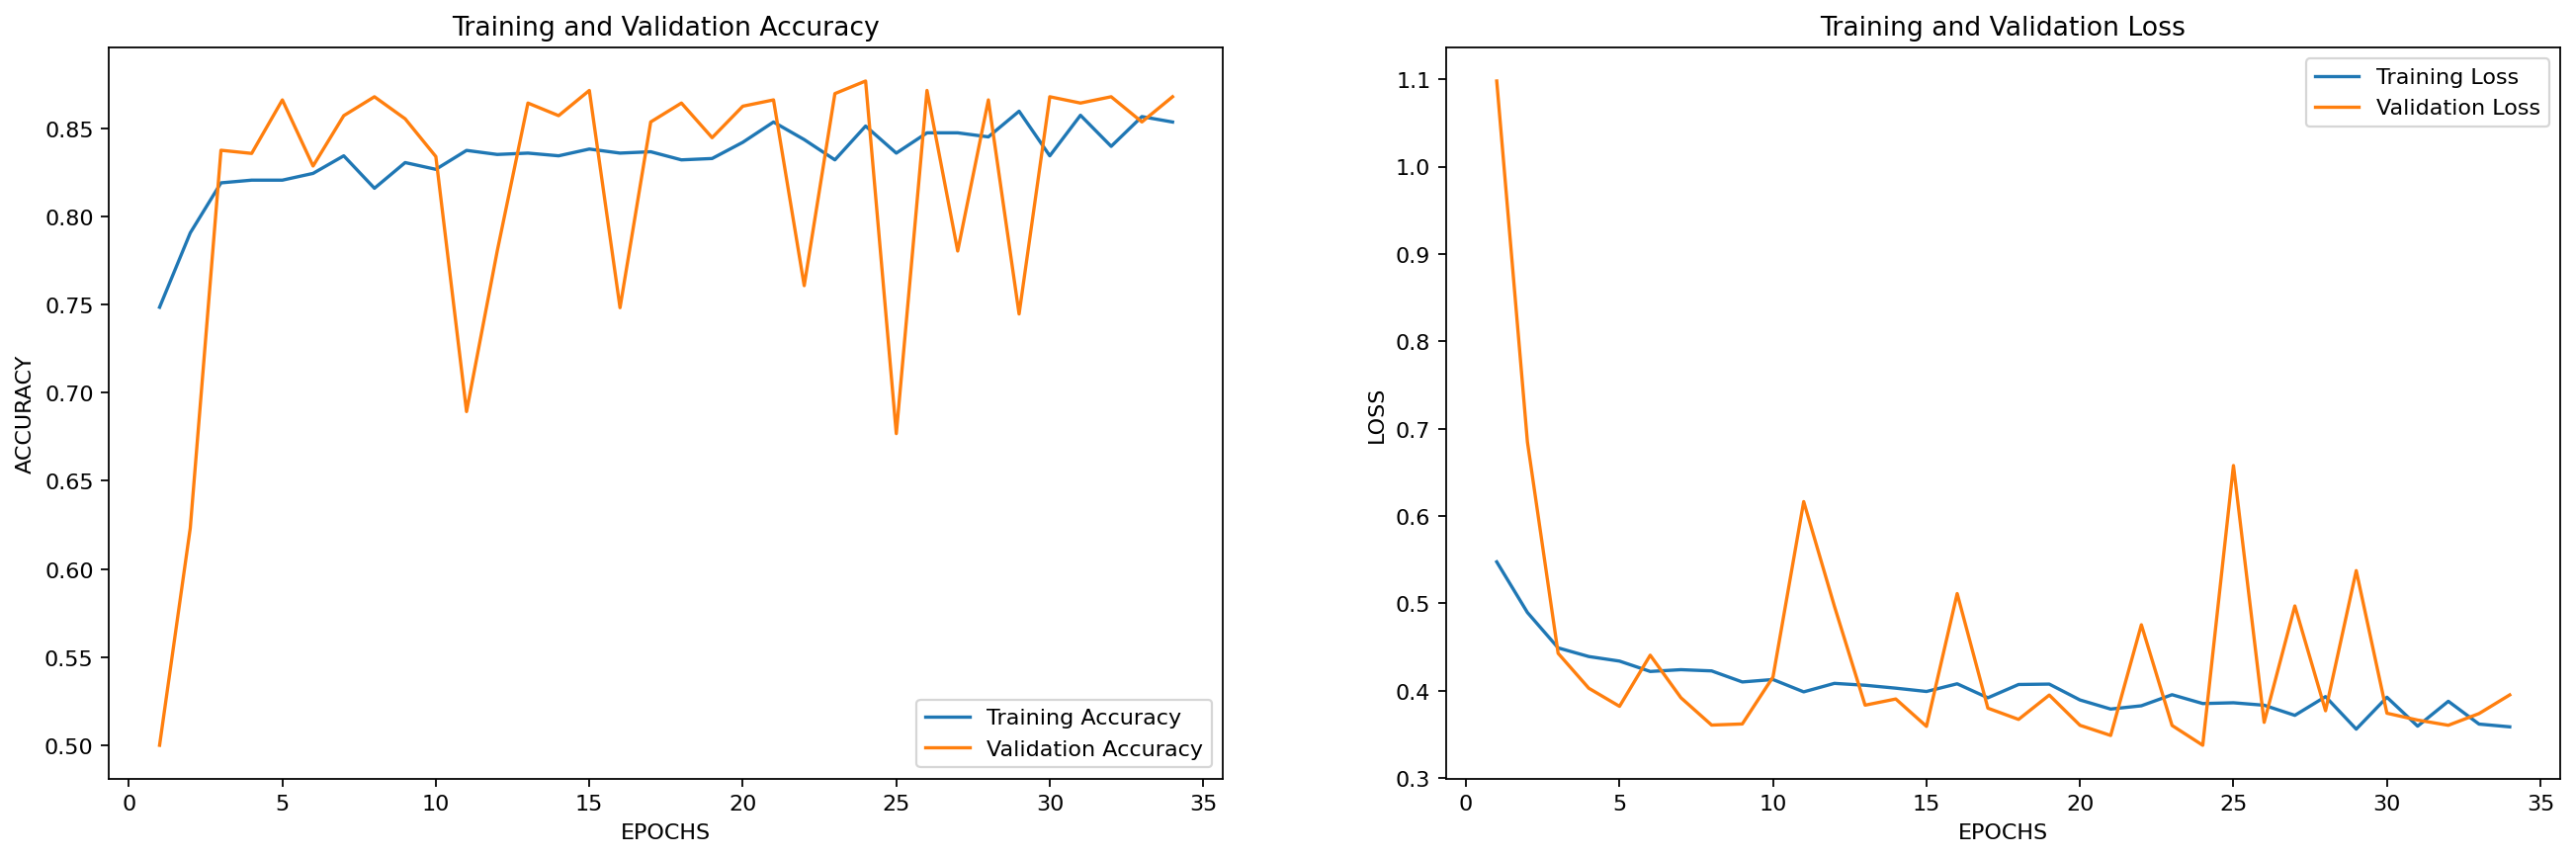

In [18]:
# Store history
store_model_history('MRNet_Model3', history.history)

# Plot training graphs
plot_acc_loss(history.history)

27/27 [==============================] - 43s 2s/step

Best cutoff Threshold = 0.320321, F-Score = 0.873

Evaluation Metrics:

Balanced Accuracy : 0.88
Precision : 0.9
Recall : 0.85
F1 Score: 0.87
ROC AUC Score : 0.9

Classification report : 
              precision    recall  f1-score   support

     Healthy       0.85      0.90      0.88       104
        Tear       0.90      0.85      0.87       105

    accuracy                           0.88       209
   macro avg       0.88      0.88      0.88       209
weighted avg       0.88      0.88      0.88       209


Confusion Matrix : 


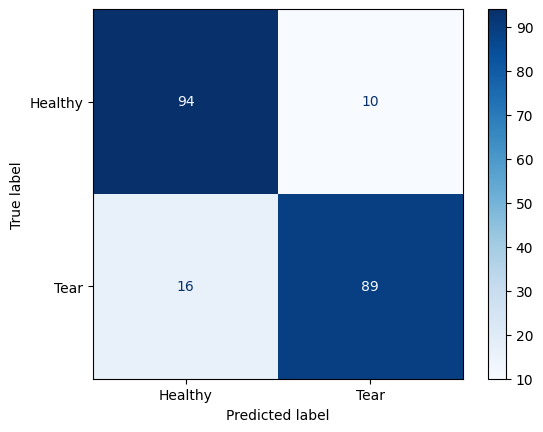

In [19]:
# Evaluate model
X_test_prob = MRNet_Model3.predict(predict_batch_generator(X_test, BATCH_SIZE))

# Now get the correct labels based on the optimal threshold
optimal_threshold = calculate_best_cutoff_threshold(y_test, X_test_prob)
X_test_pred = (X_test_prob >= optimal_threshold ).astype('int')

evaluate_model(y_test, X_test_pred.tolist(), X_test_prob.tolist(), ['Healthy', 'Tear'])